# Importar TensorFlow e Bibliotecas necessárias

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, ReLU, LeakyReLU, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import backend as K
import numpy as np
import time
import os
import pathlib
import matplotlib.pyplot as plt
import csv

from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd

import collections

# Funções Auxiliares

In [2]:
def generate_and_save_images(model, epoch, test_input):
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('cartoon/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

# Load Datsaset no Google Drive

In [ ]:
# ESTA CÉLULA NÃO DEVE SER EXECUTADA FORA DO GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')

!tar -xvzf drive/MyDrive/cartoonset100k.tgz -C ./
!pip install tensorflow-addons

# Configurações

In [4]:
img_height, img_width = 256, 256
batch_size = 128

# Carregar Dataset

Dataset: https://google.github.io/cartoonset/

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'cartoonset100k',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 100000 files belonging to 1 classes.


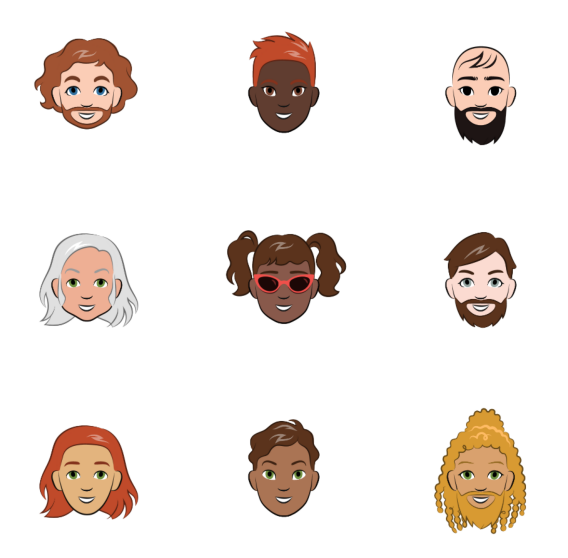

In [6]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [8]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [ ]:
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

In [10]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    return mean + K.exp(log_var / 2) * epsilon

# Definir Encoder

In [11]:
def encoder(input_encoder):
    
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
  
    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
 

    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [12]:
enc = encoder(input_encoder)

In [13]:
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 128, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 128, 128, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
lrelu_1 (LeakyReLU)             (None, 128, 128, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

# Sampler

In [14]:
input_1 = (200,)
input_2 = (200,)

In [15]:
def sampling(input_1,input_2):
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [16]:
final = sampling(input_1,input_2)

# Definir Decoder

In [17]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)
    
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
 
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

  
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [18]:
dec = decoder(input_decoder)

In [19]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
Reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 16, 16, 64)        256       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 32, 32, 64)        3692

# Optimizer e função de Loss

In [20]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    varkl_loss = kl_loss(mean, log_var)
    return  r_loss + varkl_loss

# Treinar o dataset

In [ ]:
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [ ]:
os.makedirs('cartoon/training_weights', exist_ok=True)
os.makedirs('cartoon/images', exist_ok=True)

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        print ('Start epoch {}'.format(epoch + 1))
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
 
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        enc.save_weights('cartoon/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('cartoon/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

(25, 256, 256, 3)


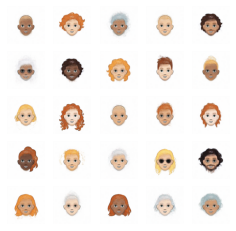

In [ ]:
train(normalized_ds, 25)

# Load dos pesos

In [22]:
enc.load_weights('./cartoon/training_weights/enc_24.h5')

In [23]:
dec.load_weights('./cartoon/training_weights/dec_24.h5')

# Criação de Cartoons

A partir do dataset

In [25]:
reconstruction = None
lat_space = None
it = 0
for i in normalized_ds:
    if it == 26:
      break
    m,v = enc.predict(i)
    latent = final([m,v])
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break

In [26]:
reconstruction.shape

(5120, 256, 256, 3)

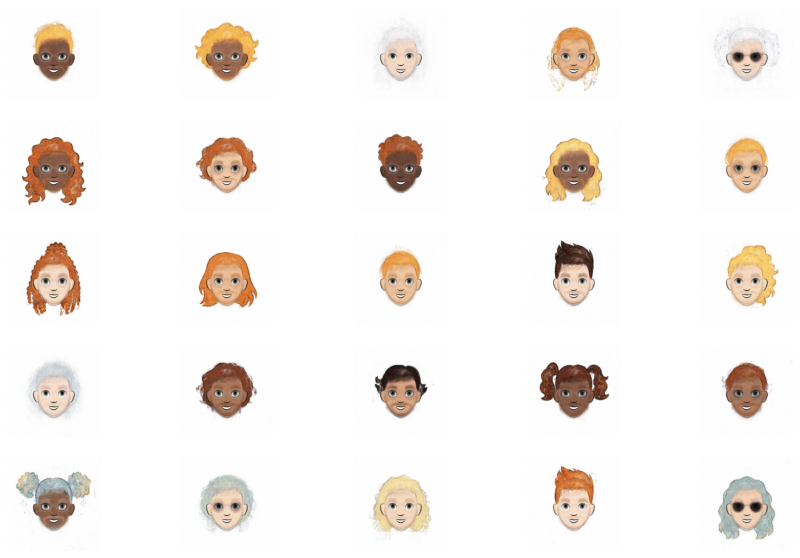

In [27]:

figsize = 15


fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    
    ax.imshow(pred)

A partir de um vector de latentes sampled com distribuição normal

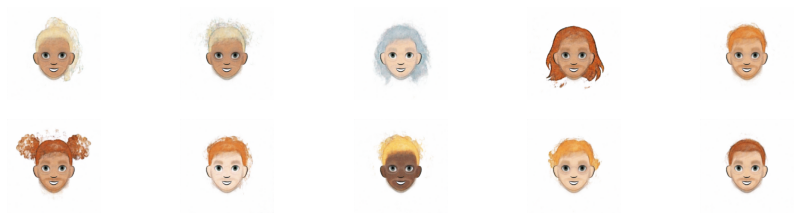

In [24]:
figsize = 15


x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)